# Backtesting Fibonacci Strategies

## Getting the Data

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util.ATR import *
from util.SMA import *
from util.plot_return import *
from util.Bollinger_bands import *
from util.load_data import *

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['H4']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01 00:00:00,635.679,636.194,635.009,635.497,95
2007-01-01 04:00:00,635.336,636.220,635.254,635.699,97
2007-01-01 08:00:00,635.780,636.225,635.201,635.993,99
2007-01-01 12:00:00,636.053,636.189,635.117,636.006,90
2007-01-01 16:00:00,635.902,636.185,635.006,635.989,96
...,...,...,...,...,...
2023-03-10 00:00:00,1831.428,1834.765,1827.974,1829.085,240
2023-03-10 04:00:00,1829.085,1834.575,1827.675,1833.405,240
2023-03-10 08:00:00,1833.415,1837.245,1830.778,1834.865,240


In [5]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


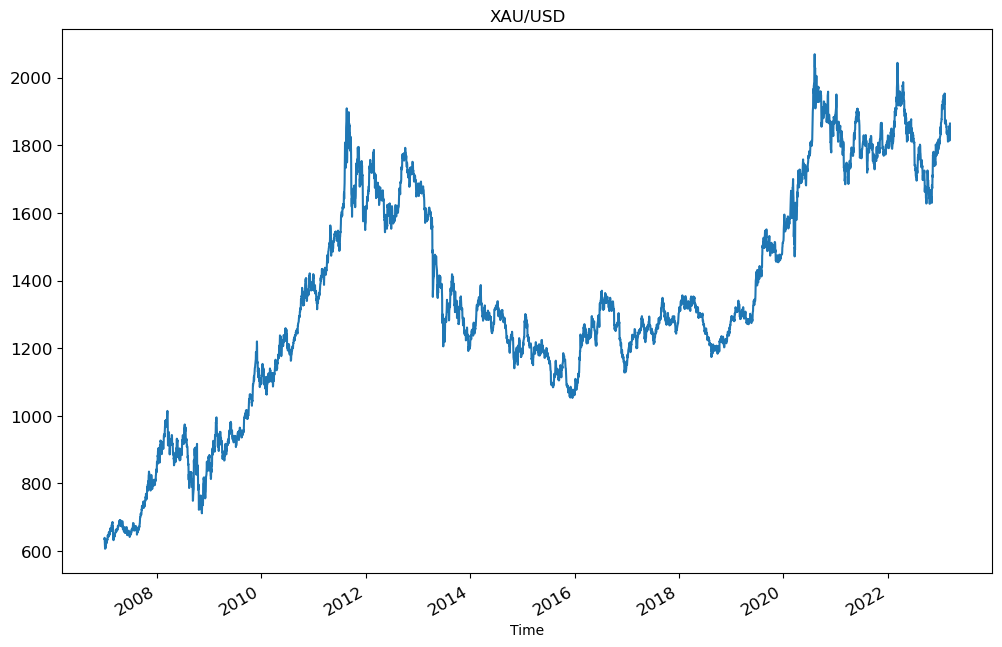

In [6]:
XAUUSD['D1'].Close.plot(figsize=(12, 8), title="XAU/USD", fontsize=12)
plt.show()

## Definde strategy

In [35]:
class Fibonacci(Strategy):
    periods = 14
    moving_av = 3
  

    def init(self):
        
        self.data.df["PP"] = (self.data.df["High_d"] + self.data.df["Low_d"] + self.data.df["Close_d"]) / 3
        self.data.df["S1"] = self.data.df["PP"] * 2 - self.data.df["High_d"]
        self.data.df["S2"] = self.data.df["PP"] - \
            (self.data.df["PP"] - self.data.df["PP"])
        self.data.df["R1"] = self.data.df["PP"] * 2 - self.data.df["Low_d"]
        self.data.df["R2"] = self.data.df["PP"] + (self.data.df["High_d"]  - self.data.df["Low_d"])

        self.data.df["position"] = np.where(self.data.df["Open"] > self.data.df["PP"], 1, -1)
        self.data.df["position"] = np.where(self.data.df["Open"] >= self.data.df["R1"], 0, self.data.df["position"])
        self.data.df["position"] = np.where(self.data.df["Open"] <= self.data.df["S1"], 0, self.data.df["position"])
        


        


    def next(self):

        position = self.data.df.loc[self.data.df.index[-1], 'position']
        
        if position == 1  :
            if self.position.is_short :
                self.position.close()
            self.buy(size=1)
         

        if position == 0 :
            if self.position.is_long :
                self.position.close()
            self.sell(size=1)
      

## Backtesting

In [36]:
account_size = 20000

In [37]:
bt = Backtest(data, Pivot_Point, cash=account_size, margin=1/2000 )
result = bt.run()
result

Start                     2007-01-01 16:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   99.992545
Equity Final [$]                    34202.886
Equity Peak [$]                     34202.886
Return [%]                           71.01443
Buy & Hold Return [%]              193.102239
Return (Ann.) [%]                    2.716471
Volatility (Ann.) [%]                4.457193
Sharpe Ratio                         0.609458
Sortino Ratio                        0.923667
Calmar Ratio                         0.336128
Max. Drawdown [%]                   -8.081667
Avg. Drawdown [%]                   -0.463613
Max. Drawdown Duration     1463 days 16:00:00
Avg. Drawdown Duration       22 days 07:00:00
# Trades                                16576
Win Rate [%]                        52.431226
Best Trade [%]                      12.298778
Worst Trade [%]                     -7.257647
Avg. Trade [%]                    

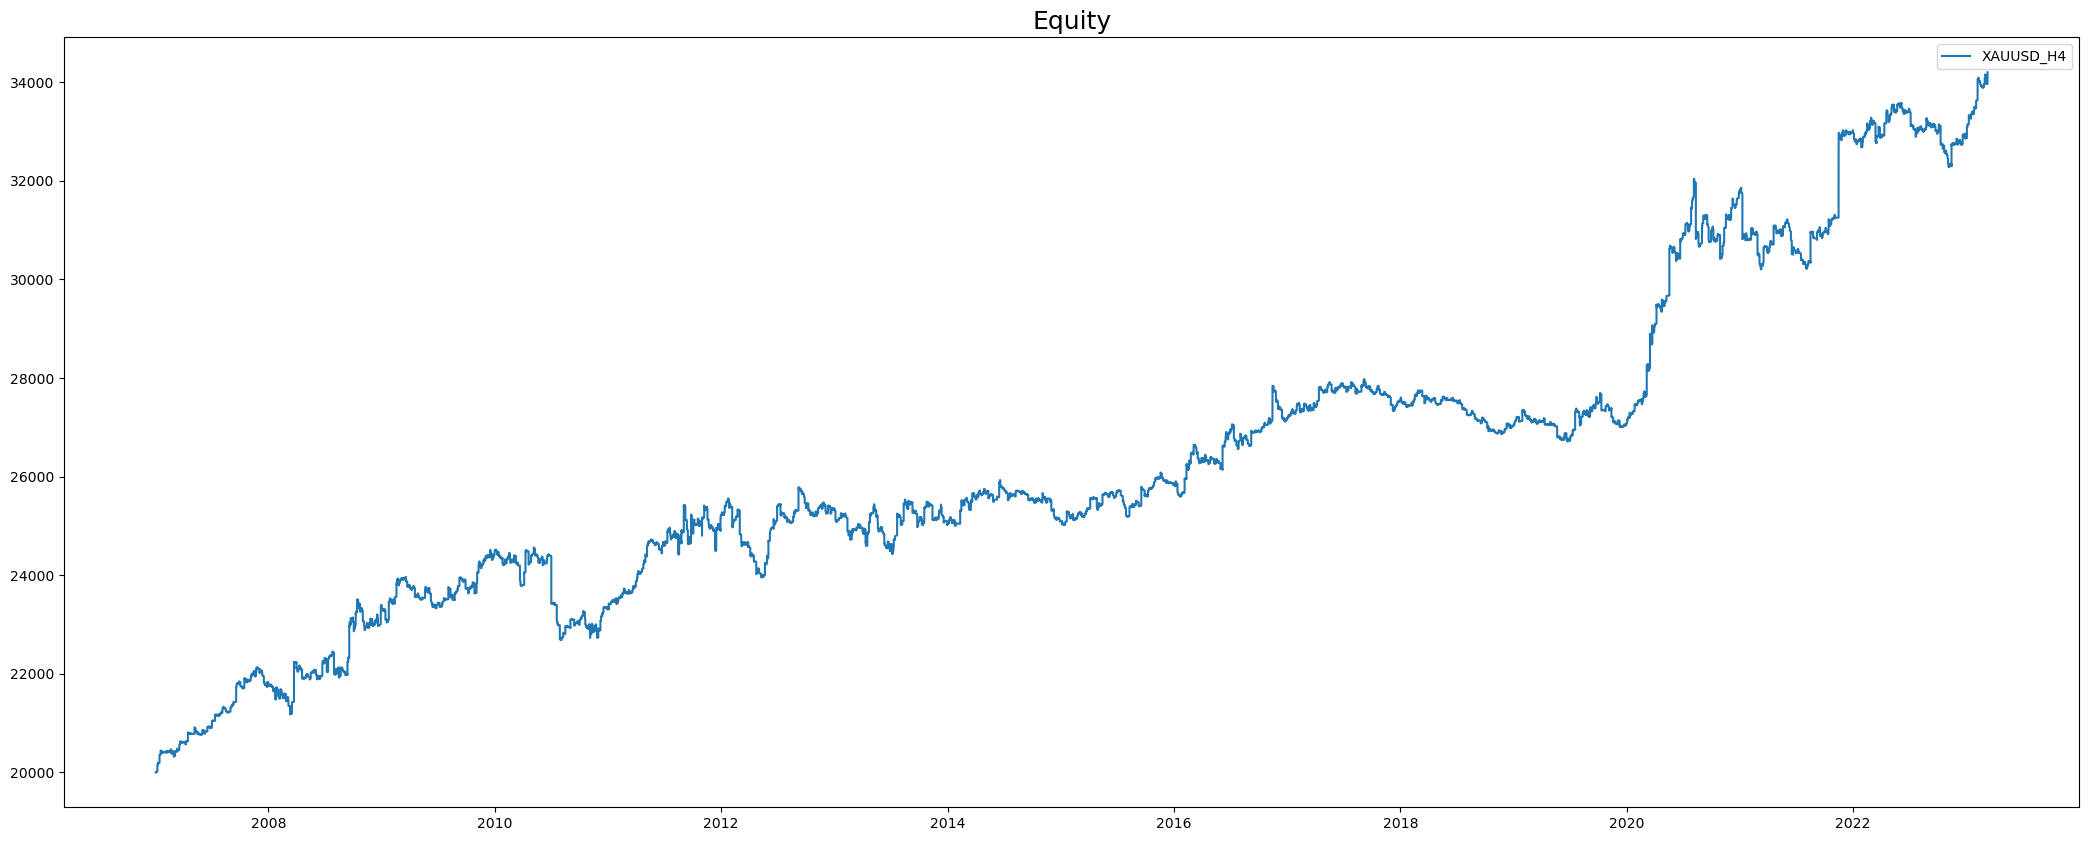

In [38]:
plot_return_trades(result['_trades'], 'XAUUSD_H4' , account_size)